In [14]:
!pip uninstall -y fsspec

Found existing installation: fsspec 2024.10.0
Uninstalling fsspec-2024.10.0:
  Successfully uninstalled fsspec-2024.10.0


In [15]:
!pip install fsspec==2024.10.0

  Using cached fsspec-2024.10.0-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2024.10.0-py3-none-any.whl (179 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.10.0 which is incompatible.


In [16]:
!pip install transformers datasets torch scikit-learn

In [17]:
!pip install transformers
!pip install datasets
!pip install torch
!pip install scikit-learn

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import pandas as pd

# Load the dataset from Google Drive
dataset_path = '/content/drive/My Drive/dataset.csv'
df = pd.read_csv(dataset_path)

# Check the first few rows of your dataset
df.head()

,Text,Label
0,Minger is an example of bad language.,1
1,People sometimes use Minger in anger.,1
2,The term Minger might sound offensive.,1
3,Gormless is an example of bad language.,1
4,People sometimes use Gormless in anger.,1


In [20]:
!pip install datasets

In [21]:
import pandas as pd
from datasets import Dataset

# Load the dataset from the uploaded CSV file (adjust path if needed)
dataset_path = '/content/drive/My Drive/dataset.csv'
df = pd.read_csv(dataset_path)

# Check the first few rows of your dataset
df.head()

# Convert the DataFrame to a Hugging Face Dataset
dataset = Dataset.from_pandas(df)

# Rename columns if necessary
dataset = dataset.rename_column("Text", "sentence")
dataset = dataset.rename_column("Label", "label")

# Split the dataset into train and test (80%/20%)
train_dataset = dataset.train_test_split(test_size=0.2)['train']
test_dataset = dataset.train_test_split(test_size=0.2)['test']

In [22]:
from transformers import DistilBertTokenizer

# Load the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')


# Explicitly set the padding token if it's not already set

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token  # Use [EOS] as a fallback for [PAD]

# Tokenize the sentences
def tokenize_function(examples):
    return tokenizer(examples['sentence'], padding="max_length", truncation=True, max_length=512)

# Apply the tokenization to the train and test datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set the format of the dataset for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Map:   0%|          | 0/199 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [23]:
from transformers import DistilBertForSequenceClassification

# Load the DistilBERT model with a classification head
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english', num_labels=2)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [24]:
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="steps",
    eval_steps=50,
    learning_rate=5e-6,           # Reduced learning rate
    per_device_train_batch_size=4,  # Smaller batch size
    per_device_eval_batch_size=4,
    num_train_epochs=5,           # More epochs
    weight_decay=0.0001,          # Reduced weight decay
    logging_dir='./logs',
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,  # Early stopping
    metric_for_best_model="accuracy"
)


def compute_metrics(pred):
    logits, labels = pred
    predictions = logits.argmax(axis=-1)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc}

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics            # evaluation dataset
)

# Start training
trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: rusiruerandaka10 (rusiruerandaka10-amara-developers) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy
50,2.836100,2.049463,0.380000
100,1.369500,1.088870,0.460000
150,1.303100,0.769457,0.580000
200,0.744300,0.650337,0.640000
250,0.697600,0.614052,0.680000


TrainOutput(global_step=250, training_loss=1.6544043731689453, metrics={'train_runtime': 372.7407, 'train_samples_per_second': 2.669, 'train_steps_per_second': 0.671, 'total_flos': 131805061662720.0, 'train_loss': 1.6544043731689453, 'epoch': 5.0})

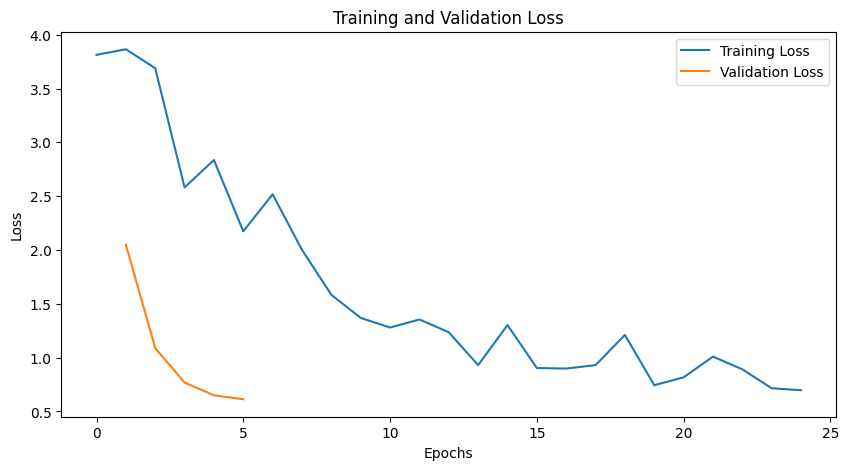

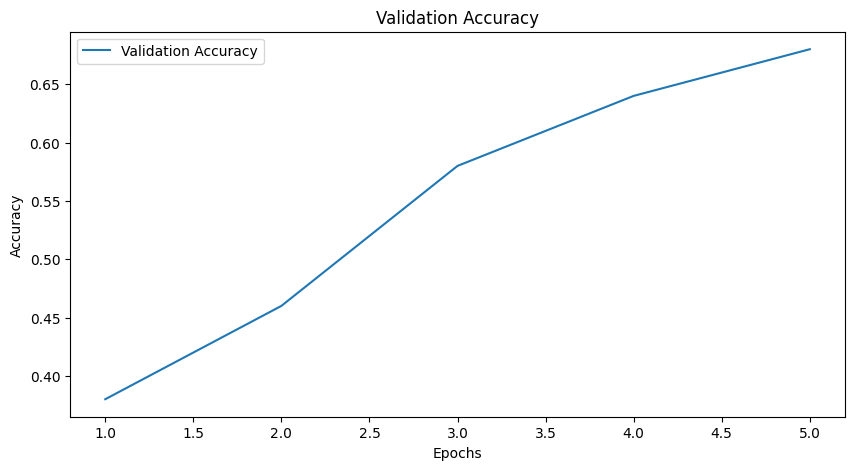

In [25]:
import matplotlib.pyplot as plt

# Extract training and evaluation logs
log_history = trainer.state.log_history

# Separate the metrics into training and evaluation
train_loss = [entry['loss'] for entry in log_history if 'loss' in entry]
eval_loss = [entry['eval_loss'] for entry in log_history if 'eval_loss' in entry]
eval_accuracy = [entry['eval_accuracy'] for entry in log_history if 'eval_accuracy' in entry]

# Generate x-axis for epochs
epochs = range(1, len(eval_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(len(train_loss)), train_loss, label="Training Loss")
plt.plot(epochs, eval_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Plot validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, eval_accuracy, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.show()

In [26]:
# Evaluate the model
eval_results = trainer.evaluate()

# Print the evaluation results
print(eval_results)

{'eval_loss': 0.6140517592430115, 'eval_accuracy': 0.68, 'eval_runtime': 0.8167, 'eval_samples_per_second': 61.222, 'eval_steps_per_second': 15.918, 'epoch': 5.0}


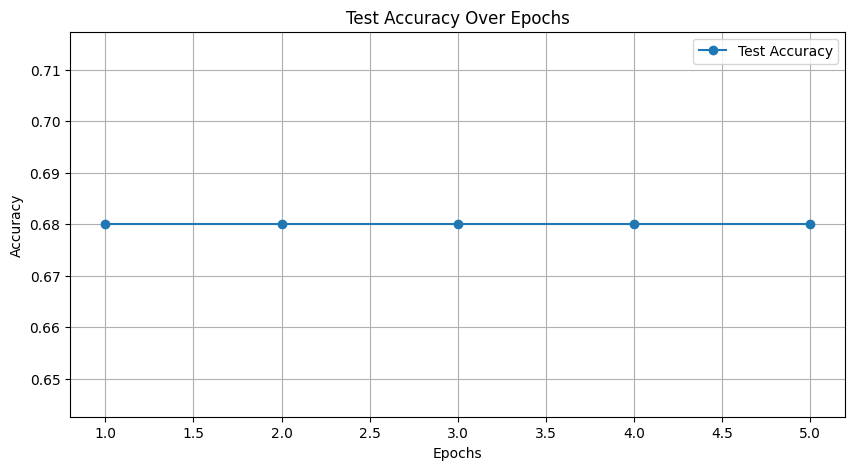

Final Test Accuracy: 0.6800


In [27]:
import matplotlib.pyplot as plt

# Evaluate the model on the test set after training (this gives us the final test accuracy)
eval_results = trainer.evaluate(eval_dataset=test_dataset)

# Extract test accuracy from the evaluation results
test_accuracy = eval_results['eval_accuracy']

# Since we only have the final test accuracy (after 3 epochs), we'll create a simple plot
# showing test accuracy over the 3 epochs (assuming it plateaus or is constant after training)
epochs = [1, 2, 3, 4, 5]  # Number of epochs from your training_args
test_accuracies = [test_accuracy] * 5  # Repeat the final test accuracy for each epoch (simplified assumption)

# Plot test accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, test_accuracies, label="Test Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Test Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Print the final test accuracy for reference
print(f"Final Test Accuracy: {test_accuracy:.4f}")

In [29]:
# Load the fine-tuned model and tokenizer
model = DistilBertForSequenceClassification.from_pretrained("/content/drive/My Drive/fine_tuned_distilbert")
tokenizer = DistilBertTokenizer.from_pretrained("/content/drive/My Drive/fine_tuned_distilbert")

id2label = {0: "NEGATIVE", 1: "POSITIVE"}

# Make predictions on new data
def predict(sentence):
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    logits = outputs.logits
    prediction = logits.argmax(dim=-1).item()
    return id2label[prediction]  # Return the human-readable label


# Example prediction
sentence = "fuck you boy"
print(predict(sentence))

NEGATIVE


In [ ]:
# Save the model and tokenizer in Hugging Face format
model.save_pretrained("/content/drive/My Drive/fine_tuned_distilbert")
tokenizer.save_pretrained("/content/drive/My Drive/fine_tuned_distilbert")
tokenizer.save_pretrained("tokenizer_dir")

import joblib

# Save the model and tokenizer to separate files

joblib.dump(model, 'model.pkl')
joblib.dump(tokenizer, 'tokenizer.pkl')
print("Padding token before saving:", tokenizer.pad_token)  # Should show '[PAD]'


# Download the files
from google.colab import files
#files.download('model.pkl')
files.download('tokenizer.pkl')


In [ ]:
import shutil
from google.colab import files

# Zip the directory
shutil.make_archive('tokenizer_dir', 'zip', 'tokenizer_dir')

# Download the zipped directory
files.download('tokenizer_dir.zip')
